In [1]:
# Importing necessary libraries
import pretty_midi
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, WeightedRandomSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.amp import autocast, GradScaler

In [2]:
# Creating function for converting MIDI file to a piano roll representation
def midi_to_pianoroll(filepath, fs=100):
    try:
        midi = pretty_midi.PrettyMIDI(filepath)
        # Normalizing piano roll
        piano_roll = midi.get_piano_roll(fs=fs) / 127.0
        # Removing extremely high/low notes since they could potentially be noise
        piano_roll = piano_roll[21:109, :]
        return piano_roll.astype(np.float32)
    except Exception as e:
        raise ValueError(f"Failed to process MIDI file '{filepath}': {e}")

In [3]:
# Creating cache builder script to reduce training time
def preprocess_and_cache(root_dir, out_dir, fs=100, max_length=1000, allowed_composers=None):
    if allowed_composers is None:
        allowed_composers = ["Bach", "Chopin", "Mozart", "Beethoven"]

    os.makedirs(out_dir, exist_ok=True)
    label_map = {composer: idx for idx, composer in enumerate(sorted(allowed_composers))}

    for composer in allowed_composers:
        composer_dir = os.path.join(root_dir, composer)
        if not os.path.isdir(composer_dir):
            continue

        for root, _, files in os.walk(composer_dir):
            for file in files:
                if not file.lower().endswith((".mid", ".midi")):
                    continue

                filepath = os.path.join(root, file)
                # Create a safe and unique filename for saving
                base_filename = f"{composer}_{file}".replace(" ", "_").replace("/", "_")
                save_path = os.path.join(out_dir, f"{base_filename}.pt")

                if os.path.exists(save_path):
                    print(f"[SKIP] {file} already processed.")
                    continue

                try:
                    roll = midi_to_pianoroll(filepath, fs=fs)
                    if roll.shape[1] > max_length:
                        roll = roll[:, :max_length]
                    else:
                        pad = max_length - roll.shape[1]
                        roll = np.pad(roll, ((0, 0), (0, pad)), mode="constant")

                    tensor = torch.tensor(roll).unsqueeze(0)
                    label = label_map[composer]

                    torch.save((tensor, label), save_path)
                    print(f"[SAVED] {file} -> {save_path}")
                except Exception as e:
                    print(f"[ERROR] {filepath} skipped. Reason: {e}")
                    
# Class to create Dataset with preprocessed tensors and oversample underrepresented composers
class CachedMidiDataset(Dataset):
    def __init__(self, cache_dir, oversample=True):
        self.cache_dir = cache_dir
        self.oversample = oversample
        self.files = []
        self._labels = []

        label_to_files = defaultdict(list)

        # Grouping files by label
        for fname in os.listdir(cache_dir):
            if fname.endswith(".pt"):
                path = os.path.join(cache_dir, fname)
                try:
                    _, label = torch.load(path)
                    label_to_files[label].append(path)
                except Exception as e:
                    print(f"[Warning] Failed to load {path}: {e}")

        if oversample:
            # Getting the largest class size
            max_len = max(len(files) for files in label_to_files.values())

            # Oversampling all classes to match max_len
            for label, files in label_to_files.items():
                if len(files) < max_len:
                    files = files + random.choices(files, k=max_len - len(files))
                self.files.extend(files)
                self._labels.extend([label] * max_len)
        else:
            # No oversampling — use as-is
            for label, files in label_to_files.items():
                self.files.extend(files)
                self._labels.extend([label] * len(files))

        # Shuffling the dataset to mix class instances
        combined = list(zip(self.files, self._labels))
        random.shuffle(combined)
        self.files, self._labels = zip(*combined)
        self.files = list(self.files)
        self._labels = list(self._labels)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        return torch.load(self.files[idx])

    @property
    def labels(self):
        return self._labels

In [4]:
# Checking that preprocessing with pretty_midi is working correctly
root_midi_dir = "midiclassics"
cache_output_dir = "cache_dir"

preprocess_and_cache(
    root_dir=root_midi_dir,
    out_dir=cache_output_dir,
    fs=100,
    max_length=1000,
    allowed_composers=['Bach', 'Chopin', 'Mozart', 'Beethoven']
)

print("PREPROCESSING COMPLETE")

dataset = CachedMidiDataset(cache_output_dir)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

for x, y in dataloader:
        print("Batch shape:", x.shape)
        print("Labels:", y)
        break

[SKIP] AveMaria.mid already processed.
[SKIP] Bwv0525 Sonate en trio n1.mid already processed.
[SKIP] Bwv0526 Sonate en trio n2.mid already processed.
[SKIP] Bwv0527 Sonate en trio n3.mid already processed.
[SKIP] Bwv0528 Sonate en trio n4.mid already processed.
[SKIP] Bwv0529 Sonate en trio n5.mid already processed.
[SKIP] Bwv0530 Sonate en trio n6.mid already processed.
[SKIP] Bwv0531 Prelude and Fugue.mid already processed.
[SKIP] Bwv0532 Toccata and Fugue.mid already processed.
[SKIP] Bwv0533 Prelude and Fugue.mid already processed.
[SKIP] Bwv0535 Prelude and Fugue.mid already processed.
[SKIP] Bwv0536 Prelude and Fugue.mid already processed.
[SKIP] Bwv0537 Fantasia and Fugue.mid already processed.
[SKIP] Bwv0538 Toccata and Fugue ''Dorian''.mid already processed.
[SKIP] Bwv0539 Prelude and Fugue.mid already processed.
[SKIP] Bwv0540 Toccata and Fugue.mid already processed.
[SKIP] Bwv0541 Prelude and Fugue.mid already processed.
[SKIP] Bwv0542 Fantasia and Fugue.mid already process

C:\Users\seanp\AppData\Local\Temp\ipykernel_13304\774454924.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _, label = torch.load(path)


Batch shape: torch.Size([16, 1, 88, 1000])
Labels: tensor([2, 1, 0, 1, 3, 0, 2, 1, 3, 3, 0, 1, 2, 1, 0, 3])


C:\Users\seanp\AppData\Local\Temp\ipykernel_13304\774454924.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(self.files[idx])


In [5]:
# Function for creating more balanced train/val datasets
def stratified_split(dataset, test_size=0.2, random_state=0):
    # Extracting labels from cached files
    labels = [int(torch.load(dataset.files[i])[1]) for i in range(len(dataset))]
    
    # Stratified split using the labels
    train_idx, val_idx = train_test_split(
        range(len(labels)),
        test_size=test_size,
        random_state=random_state,
        stratify=labels
    )

    return Subset(dataset, train_idx), Subset(dataset, val_idx)

In [6]:
# Updating model to be a bi-directional LSTM with dropout and batch normalization
class CNNBiLSTMClassifier(nn.Module):
    def __init__(self, input_size=128, num_classes=4, dropout_p=0.3):
        super(CNNBiLSTMClassifier, self).__init__()

        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
        )

        self.lstm = nn.LSTM(
            input_size=input_size,  
            hidden_size=64,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_p
        )

        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(64 * 2, num_classes)  

    def forward(self, x):
        b, c, f, t = x.size()                  
        x = x.permute(0, 3, 1, 2)              
        x = x.reshape(b, t, c * f)             

        x, _ = self.lstm(x)                    
        x = x[:, -1, :]                        

        x = self.dropout(x)
        x = self.fc(x)
        return x

In [7]:
# Creating early stopping class
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def step(self, val_loss, model):
        self.__call__(val_loss, model)

In [ ]:
# Setting up parameters for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
train_dataset, val_dataset = stratified_split(dataset)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)


# Creating model training/evaluation function for use with multiple models
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device,
                       num_epochs=20, early_stopping=None, use_amp=True):
    
    model = model.to(device)
    scaler = GradScaler() if use_amp else None

    # Allowing PyTorch to choose fastest convolution algorithms to help with training speed
    torch.backends.cudnn.benchmark = True  
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        start_time = time.time()

        for i, (inputs, labels) in enumerate(train_loader):
            print(f"Batch {i+1}/{len(train_loader)}")
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            if use_amp:
                with autocast(device_type=device.type):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast(device_type=device.type) if use_amp else torch.no_grad():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1:02d}: "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Time: {time.time() - start_time:.1f}s")

        # Early stopping
        if early_stopping:
            early_stopping.step(avg_val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break

    return model, val_acc

C:\Users\seanp\AppData\Local\Temp\ipykernel_13304\1493003310.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = [int(torch.load(dataset.files[i])[1]) for i in rang

In [9]:
# Training/evaluation for first model
model1 = CNNBiLSTMClassifier(input_size=88, num_classes=4, dropout_p=0.4)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-4)
early_stopping1 = EarlyStopping(patience=15, delta=0.01)
trained_model1, acc1 = train_and_evaluate(model1, train_loader, val_loader, num_epochs=100, criterion=criterion, optimizer=optimizer1, device=device, early_stopping=early_stopping1)

C:\Users\seanp\AppData\Local\Temp\ipykernel_13304\774454924.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(self.files[idx])


Batch 1/52
Batch 2/52
Batch 3/52
Batch 4/52
Batch 5/52
Batch 6/52
Batch 7/52
Batch 8/52
Batch 9/52
Batch 10/52
Batch 11/52
Batch 12/52
Batch 13/52
Batch 14/52
Batch 15/52
Batch 16/52
Batch 17/52
Batch 18/52
Batch 19/52
Batch 20/52
Batch 21/52
Batch 22/52
Batch 23/52
Batch 24/52
Batch 25/52
Batch 26/52
Batch 27/52
Batch 28/52
Batch 29/52
Batch 30/52
Batch 31/52
Batch 32/52
Batch 33/52
Batch 34/52
Batch 35/52
Batch 36/52
Batch 37/52
Batch 38/52
Batch 39/52
Batch 40/52
Batch 41/52
Batch 42/52
Batch 43/52
Batch 44/52
Batch 45/52
Batch 46/52
Batch 47/52
Batch 48/52
Batch 49/52
Batch 50/52
Batch 51/52
Batch 52/52
Epoch 01: Train Loss: 1.3881, Train Acc: 0.2488, Val Loss: 1.3860, Val Acc: 0.2549, Time: 2.9s
Batch 1/52
Batch 2/52
Batch 3/52
Batch 4/52
Batch 5/52
Batch 6/52
Batch 7/52
Batch 8/52
Batch 9/52
Batch 10/52
Batch 11/52
Batch 12/52
Batch 13/52
Batch 14/52
Batch 15/52
Batch 16/52
Batch 17/52
Batch 18/52
Batch 19/52
Batch 20/52
Batch 21/52
Batch 22/52
Batch 23/52
Batch 24/52
Batch 25/52

In [10]:
# Trying out a different model structure to improve performance
class CNNBiLSTMClassifier2(nn.Module):
    def __init__(self, input_size=256, num_classes=4, dropout_p=0.4):
        super(CNNBiLSTMClassifier2, self).__init__()

        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((1, None))  
        )

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=128,
            num_layers=3,
            bidirectional=True,
            dropout=dropout_p,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 2, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)        
        x = x.squeeze(2)       
        x = x.permute(0, 2, 1) 

        lstm_out, _ = self.lstm(x)  
        x = lstm_out[:, -1, :]     

        return self.classifier(x)

In [11]:
# Training/evaluation for second model
model2 = CNNBiLSTMClassifier2(input_size=256, num_classes=4, dropout_p=0.4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-4)
early_stopping2 = EarlyStopping(patience=15, delta=0.01)
trained_model2, acc2 = train_and_evaluate(model2, train_loader, val_loader, num_epochs=100, criterion=criterion, optimizer=optimizer2, device=device, early_stopping=early_stopping2)

Batch 1/52


C:\Users\seanp\AppData\Local\Temp\ipykernel_13304\774454924.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(self.files[idx])


Batch 2/52
Batch 3/52
Batch 4/52
Batch 5/52
Batch 6/52
Batch 7/52
Batch 8/52
Batch 9/52
Batch 10/52
Batch 11/52
Batch 12/52
Batch 13/52
Batch 14/52
Batch 15/52
Batch 16/52
Batch 17/52
Batch 18/52
Batch 19/52
Batch 20/52
Batch 21/52
Batch 22/52
Batch 23/52
Batch 24/52
Batch 25/52
Batch 26/52
Batch 27/52
Batch 28/52
Batch 29/52
Batch 30/52
Batch 31/52
Batch 32/52
Batch 33/52
Batch 34/52
Batch 35/52
Batch 36/52
Batch 37/52
Batch 38/52
Batch 39/52
Batch 40/52
Batch 41/52
Batch 42/52
Batch 43/52
Batch 44/52
Batch 45/52
Batch 46/52
Batch 47/52
Batch 48/52
Batch 49/52
Batch 50/52
Batch 51/52
Batch 52/52
Epoch 01: Train Loss: 1.3676, Train Acc: 0.3141, Val Loss: 1.3468, Val Acc: 0.3476, Time: 6.8s
Batch 1/52
Batch 2/52
Batch 3/52
Batch 4/52
Batch 5/52
Batch 6/52
Batch 7/52
Batch 8/52
Batch 9/52
Batch 10/52
Batch 11/52
Batch 12/52
Batch 13/52
Batch 14/52
Batch 15/52
Batch 16/52
Batch 17/52
Batch 18/52
Batch 19/52
Batch 20/52
Batch 21/52
Batch 22/52
Batch 23/52
Batch 24/52
Batch 25/52
Batch 26/5

In [12]:
# Third iteration of the model with an attention mechanism added
class CNNBiLSTMAttentionClassifier(nn.Module):
    def __init__(self, input_size=256, num_classes=4, dropout_p=0.4):
        super(CNNBiLSTMAttentionClassifier, self).__init__()

        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((1, None))  
        )

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=128,
            num_layers=3,
            bidirectional=True,
            dropout=dropout_p,
            batch_first=True
        )

        # Attention layer
        self.attention = nn.Linear(128 * 2, 1) 

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)        
        x = x.squeeze(2)       
        x = x.permute(0, 2, 1) 

        lstm_out, _ = self.lstm(x) 

        # Attention mechanism
        attn_weights = self.attention(lstm_out)             
        attn_weights = torch.softmax(attn_weights, dim=1)   
        context = torch.sum(attn_weights * lstm_out, dim=1) 

        return self.classifier(context)

In [13]:
# Training/evaluation for third model
model3 = CNNBiLSTMAttentionClassifier(input_size=256, num_classes=4, dropout_p=0.4)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-4)
early_stopping3 = EarlyStopping(patience=15, delta=0.01)
trained_model3, acc3 = train_and_evaluate(model3, train_loader, val_loader, num_epochs=100, criterion=criterion, optimizer=optimizer3, device=device, early_stopping=early_stopping3)

Batch 1/52
Batch 2/52


C:\Users\seanp\AppData\Local\Temp\ipykernel_13304\774454924.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(self.files[idx])


Batch 3/52
Batch 4/52
Batch 5/52
Batch 6/52
Batch 7/52
Batch 8/52
Batch 9/52
Batch 10/52
Batch 11/52
Batch 12/52
Batch 13/52
Batch 14/52
Batch 15/52
Batch 16/52
Batch 17/52
Batch 18/52
Batch 19/52
Batch 20/52
Batch 21/52
Batch 22/52
Batch 23/52
Batch 24/52
Batch 25/52
Batch 26/52
Batch 27/52
Batch 28/52
Batch 29/52
Batch 30/52
Batch 31/52
Batch 32/52
Batch 33/52
Batch 34/52
Batch 35/52
Batch 36/52
Batch 37/52
Batch 38/52
Batch 39/52
Batch 40/52
Batch 41/52
Batch 42/52
Batch 43/52
Batch 44/52
Batch 45/52
Batch 46/52
Batch 47/52
Batch 48/52
Batch 49/52
Batch 50/52
Batch 51/52
Batch 52/52
Epoch 01: Train Loss: 1.3444, Train Acc: 0.3675, Val Loss: 1.2923, Val Acc: 0.4098, Time: 5.1s
Batch 1/52
Batch 2/52
Batch 3/52
Batch 4/52
Batch 5/52
Batch 6/52
Batch 7/52
Batch 8/52
Batch 9/52
Batch 10/52
Batch 11/52
Batch 12/52
Batch 13/52
Batch 14/52
Batch 15/52
Batch 16/52
Batch 17/52
Batch 18/52
Batch 19/52
Batch 20/52
Batch 21/52
Batch 22/52
Batch 23/52
Batch 24/52
Batch 25/52
Batch 26/52
Batch 27/

C:\Users\seanp\AppData\Local\Temp\ipykernel_13304\774454924.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(self.files[idx])



Confusion Matrix (% per actual class):
            Bach        Beethoven   Chopin      Mozart      
------------------------------------------------------------
Bach              61.5%      14.1%       8.3%      16.1%
Beethoven          3.9%      68.8%       4.4%      22.9%
Chopin            10.2%       8.8%      73.7%       7.3%
Mozart             7.8%      16.6%       2.0%      73.7%

Note: Rows = Actual, Columns = Predicted


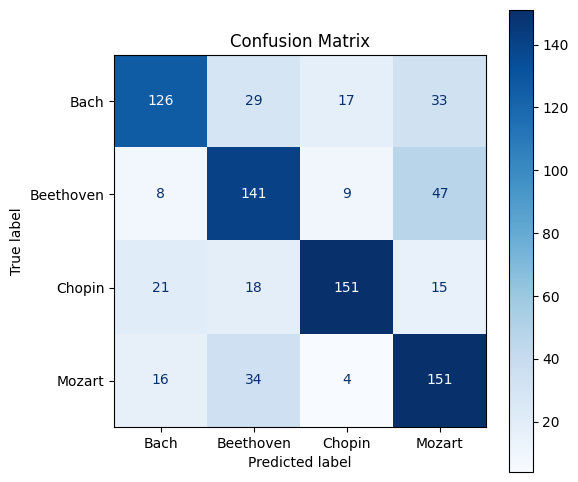

C:\Users\seanp\AppData\Local\Temp\ipykernel_13304\774454924.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(self.files[idx])



Confusion Matrix (% per actual class):
            Bach        Beethoven   Chopin      Mozart      
------------------------------------------------------------
Bach              90.2%       2.4%       2.0%       5.4%
Beethoven          0.0%      99.0%       0.0%       1.0%
Chopin             1.0%       0.0%      99.0%       0.0%
Mozart             3.4%       1.0%       0.0%      95.6%

Note: Rows = Actual, Columns = Predicted


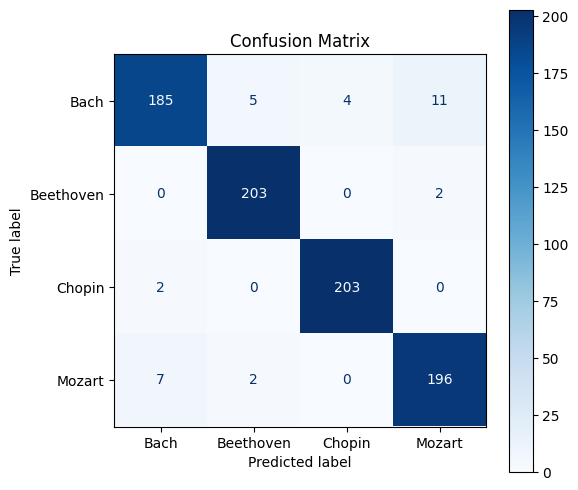

C:\Users\seanp\AppData\Local\Temp\ipykernel_13304\774454924.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(self.files[idx])



Confusion Matrix (% per actual class):
            Bach        Beethoven   Chopin      Mozart      
------------------------------------------------------------
Bach              93.2%       1.5%       0.5%       4.9%
Beethoven          0.0%     100.0%       0.0%       0.0%
Chopin             0.0%       0.0%     100.0%       0.0%
Mozart             2.0%       3.9%       0.0%      94.1%

Note: Rows = Actual, Columns = Predicted


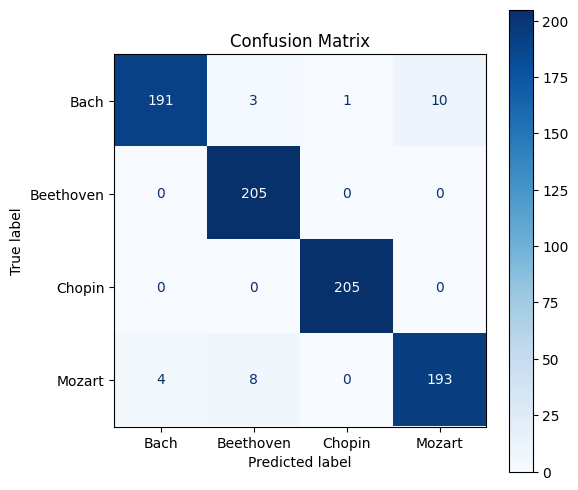

In [15]:
# Creating confusion matrix (both visual and printed) to visualize model's effectiveness at predicting each composer
def evaluate_confusion_matrix(model, dataloader, device, class_names, 
                               show_plot=True, show_text=True):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    if show_text:
        # Normalize rows to percentages
        cm_percent = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True) * 100

        # Print header
        print("\nConfusion Matrix (% per actual class):")
        header = f"{'':<12}" + "".join(f"{name:<12}" for name in class_names)
        print(header)
        print("-" * len(header))

        # Print rows
        for i, row in enumerate(cm_percent):
            row_text = f"{class_names[i]:<12}" + "".join(f"{val:>10.1f}%" for val in row)
            print(row_text)

        print("\nNote: Rows = Actual, Columns = Predicted")

    if show_plot:
        fig, ax = plt.subplots(figsize=(6, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()
    
class_names = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

evaluate_confusion_matrix(model1, val_loader, device, class_names)
evaluate_confusion_matrix(model2, val_loader, device, class_names)
evaluate_confusion_matrix(model3, val_loader, device, class_names)